First, we load up some useful libraries for visualization and data structures.

In [59]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.axes as axes
import copy
import random
from queue import PriorityQueue
import functools

Next we need a Maze class for pathfinding. It will help to have read the RedBlobGames [A\* tutorial](http://www.redblobgames.com/pathfinding/a-star/introduction.html) before continuing.

These Mazes are defined in ASCII diagrams and can have walls ("#"), empty spaces ("."), switches (numbers), and doors (letters; closed are uppercase). The "0" switch toggles the open status of all the "a" doors, "1" goes to the "b" doors, etc. Mazes can also contain pits: "?" pits have a 30% chance of killing the player and "!" pits have a 60% chance. Every maze has one player start location "@" and one goal square "X". Walls and closed doors block movement.

[(1, 0), (0, -1), (0, 1), 'switch']


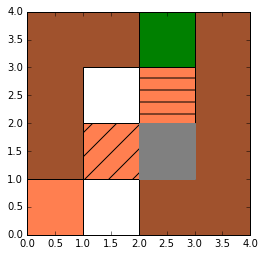

In [60]:
#teacher code
@functools.total_ordering
class Maze:
    SwitchMap = {"0":"a", "1":"b", "2":"c", "3":"d", "4":"e", "5":"f", "6":"g", "7":"h", "8":"i", "9":"j"}
    Colors = {"a":"coral","b":"tan","c":"palegreen","d":"blue","e":"cyan","f":"magenta","g":"yellow","h":"olive","i":"purple","j":"darkgreen",
              "0":"coral","1":"tan","2":"palegreen","3":"blue","4":"cyan","5":"magenta","6":"yellow","7":"olive","8":"purple","9":"darkgreen",
             "?":"orange",
             "!":"red",
             "x":"green","@":"gray",
             "#":"sienna",".":"white"}
    
    def __init__(self,rows):
        self.grid = [list(r) for r in rows]
        self.grid.reverse()
        height = len(self.grid)
        width = len(self.grid[0])
        self.exit_pos = None
        self.player_pos = None
        self.player_alive = True
        self.cost = 0
        self.path = []
        for y in range(0,height):
            assert len(self.grid[y]) == width, "All rows must be equal length!"
            for x in range(0,width):
                c = self.grid[y][x]
                assert c == "#" or c == "." or c == "!" or c == "?" or c == "@" or c.isalnum()
                if c.lower() == "x":
                    assert self.exit_pos == None
                    self.exit_pos = (x,y)
                if c == "@":
                    assert self.player_pos == None
                    self.player_pos = (x,y)
                    self.grid[y][x] = "."
    
    def clone(self):
        return copy.deepcopy(self)
    
    def toggle_cell(self,switchnum,c):
        if c.isalpha() and Maze.SwitchMap[switchnum] == c.lower():
            if c.islower():
                return c.upper()
            else:
                return c.lower()
        return c
    
    def toggle(self):
        assert self.player_alive
        height = len(self.grid)
        width = len(self.grid[0])
        (px,py) = self.player_pos
        switchnum = self.grid[py][px]
        assert switchnum.isnumeric()
        for y in range(0,height):
            for x in range(0,width):
                self.grid[y][x] = self.toggle_cell(switchnum,self.grid[y][x])
    
    def is_free(self,x,y):
        if y < 0 or y >= len(self.grid):
            return False
        if x < 0 or x >= len(self.grid[0]):
            return False
        cell = self.grid[y][x]
        return (
            cell == "." or cell == "?" 
            or cell == "!" or cell == "X" or 
            (cell.isalpha() and cell.islower()) or cell.isnumeric()
        )
    
    def move_player(self,dx,dy):
        assert self.player_alive
        assert abs(dx)+abs(dy) == 1
        (x,y) = self.player_pos
        (newx,newy) = (x+dx,y+dy)
        assert self.is_free(newx,newy)
        self.player_pos = (x+dx,y+dy)
        cell = self.grid[y+dy][x+dx]
        if cell == "?" and random.random() < 0.3:
            self.player_alive = False
        if cell == "!" and random.random() < 0.6:
            self.player_alive = False
    
    def available_moves(self):
        if not self.player_alive:
            return []
        (x,y) = self.player_pos
        can_switch = self.grid[y][x].isnumeric()
        return [(dx,dy) for (dx,dy) in [(-1,0),(1,0),(0,-1),(0,1)] if self.is_free(x+dx,y+dy)] + (
            ["switch"] if can_switch else []
        )
    
    def is_at_exit(self):
        return self.player_alive and self.player_pos == self.exit_pos
    
    def draw(self):
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(1,1,1, aspect='equal')
        ax1.set_axis_bgcolor('sienna')
        height = len(self.grid)
        width = len(self.grid[0])
        ax1.set_xlim([0,width])
        ax1.set_ylim([0,height])
        for y in range(0,height):
            for x in range(0,width):
                cell = self.grid[y][x]
                if cell == "#": continue
                is_door = cell.isalpha() and cell.lower() != "x"
                is_pit = cell == "?" or cell == "!"
                is_open = is_door and cell.islower()
                is_switch = cell.isnumeric()
                ax1.add_patch(
                    patches.Rectangle((x, y),
                                      1,1,
                                      fill=True,
                                      facecolor=Maze.Colors[cell.lower()],
                                      edgecolor="black",
                                      hatch="/" if is_switch else ("-" if (is_door and not is_open) else None),
                                      label=cell)
                )
        ax1.add_patch(
            patches.Rectangle(self.player_pos,
                              1,1,
                              fill=True,
                              hatch="x" if not self.player_alive else None,
                              facecolor=Maze.Colors["@"] if self.player_alive else "black",
                              edgecolor=Maze.Colors["@"] if self.player_alive else "white")
        )
        plt.show(fig1)

    def __hash__(self):
        return hash(str(self.grid)) % 1000007 + hash(self.player_pos) % 1000007 + hash(self.player_alive) % 1000007
    
    def _is_valid_operand(self, other):
        return (hasattr(other, "grid") and hasattr(other, "player_pos") and hasattr(other, "player_alive"))
    
    def __eq__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return ((self.grid, self.player_pos, self.player_alive) ==
                (other.grid, other.player_pos, other.player_alive))
    
    def __lt__(self, other):
        if not self._is_valid_operand(other):
            return NotImplemented
        return ((self.grid, self.player_pos, self.player_alive) <
                (other.grid, other.player_pos, other.player_alive))

    def color_graph(self, path): #color the graph based on the path; pass in the maze object, and the final path
        for (x, y) in path: #iterate through all locations stored in the path using a for loop; unzip the tuples by assigning the variable x to the x-coordinate of the location and the variable y to the y-coordinate of the location 
            self.grid[y][x] = "d" #call the grid function defined above and pass in the x and y variable to color that square "blue" (which in the constructor corresponds with "d")
        
sample=Maze([
        "##X#",
        "#.A#",
        "#0?#",
        "a@##"
    ])
sample.move_player(0,1)
print(sample.available_moves())
sample.move_player(1,0)
sample.draw()

# Assignment 1

Write a function to solve pathfinding and switch-and-door puzzles with one of the heuristic search algorithms described during the lecture. Try it on the provided sample puzzles; if a puzzle gives your algorithm trouble, try to explain why that happens. Make sure the path you're getting is the actual shortest path!

Try to get this assignment done by Friday; the other two may take a little longer but the sooner you attempt them the earlier you can get feedback!

You may also try visualizing paths through the maze, implementing several different heuristic searches, comparing against aheuristic search, etc.

Generating mazes automatically would also be a great exercise!

In [61]:
#Alisha Singh, 18 Jul. 2016

# Return a path which solves the maze: a sequence of elements like (dx,dy) or "switch".
# You can use maze.exit_pos and query maze.grid[row][column] to investigate the maze

def manhattan(end, current): #method that defines manhattan distance, takes in the maze ending position and the player's current position as arguments
    (x1, y1) = end #assigns variable x1 to the x-coordinate of end location, variable y1 to the y-coordinate of end location
    (x2, y2) = current #assigns variable x2 to the x-coordinate of the player location, and variable y2 as the y-coordinate of the player location 
    return abs(x2-x1) + abs(y2-y1) #method calculates and returns manhattan distance; manhattan distance = the absolute value of the difference in x-coordinates plus the absolute value of the difference in y-coordinates

def heuristic(maze):
    #maze.path = [] and maze.cost = 0 are not declared and initialized because that is done in the maze class, and those attributes transfer over to the instance of the class "maze"
    
    frontier = PriorityQueue() #declare the priority queue "frontier"; priority queues are data structures that organize elements by priority (low priority to high priority)
    frontier.put((0, maze)) #put a tuple with cost 0 and the original maze object into the frontier queue

    visited = set([maze]) #declare the set "visited"; a set is good to use because sets do not store duplicate copies of elements like lists do (do not want to store duplicate maze instances)
    
    while not frontier.empty(): #while frontier is not empty
        (priority, current_maze) = frontier.get() #retrieve and delete the first tuple in the frontier queue; initialize the variable "priority" to be the 1st element in the tuple, and "current_maze" to be the maze object in the tuple  
        
        if current_maze.is_at_exit(): #if the current player_pos is the ending_pos
            current_maze.path.pop() #retrieve and delete the first element of the current_maze.path
            return current_maze.path #return the current_maze.path, program exits out of while loop  
        
        moves = current_maze.available_moves() #initialize the variable moves to be the available neighbors from current node in (dx,dy) form from the original node
        
        for m in moves: #for loop, iterate through each move; variable m becomes each (dx, dy) neighbor each time the for loop iterates
            new_maze = current_maze.clone() #clone the maze, because the player position changed two lines above; assign the cloned maze to new_maze
            
            if m == "switch": #if the current neighbor is a switch...
                new_maze.toggle() #toggle the switch    
            else: #else
                (dx, dy) = m #assign variable dx to m's change in x-coordinate from the previous position and variable dy to m's change in y-coordinates from the previous position
                new_maze.move_player(dx,dy) #move the player on the copied maze to the next node; put in dx, dy as arguments because the method move_player does not take the tuple m as an argument        
                new_maze.cost = current_maze.cost + 1 #assign the cost of the copied maze to be the cost of the original maze + 1 (for moving one square)
                    
            if new_maze not in visited or new_maze.cost < current_maze.cost: #if statement checks if the node has been visited before or if this path is a more cost-efficient way of getting to the node than a pre-visited path
                priority = new_maze.cost + manhattan(new_maze.exit_pos,new_maze.player_pos) #the variable priority computes and takes into account the cost and the manhattan distance from the goal
                new_path = list(current_maze.path) #assign the path of the current maze to the variable new_path; cast the variable new_path to be a list
                new_path.append(new_maze.player_pos) #use the list append function to add the player's current position to new_path
                new_maze.path = new_path #assign the path attribute of maze instance "new_maze" to be new_path; doing so wraps the new path inside the entire maze object
                frontier.put((priority, new_maze)) #put the updated priority and new_maze object into a tuple and put into the frontier priority queue                  
                visited.add(new_maze) #add the new_maze instance to the visited set
                    
                  
    return [] #if there is no solution to the maze, the frontier will eventually run empty and the program will exit out of the while loop. The program will then return an empty list b/c there is no solution.

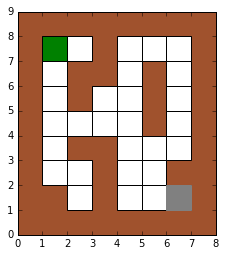

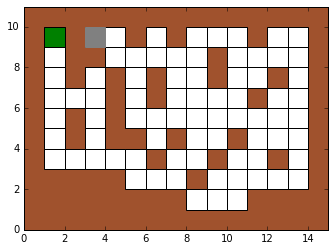

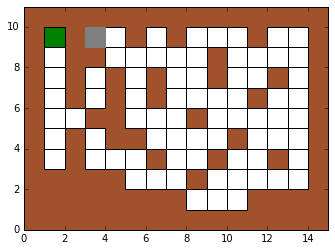

In [62]:
def maze1():
    return Maze([
        "########",
        "#X.#...#",
        "#.##.#.#",
        "#.#..#.#",
        "#....#.#",
        "#.##...#",
        "#..#..##",
        "##.#..@#",
        "########"
    ])

maze1().draw()

def maze2():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#...#.#....#..#",
        "#.#.#.........#",
        "#.#.##.#..#...#",
        "#.....#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze2().draw()

def mazeUnsolvable1():
    return Maze([
        "###############",
        "#X#@.#.#...#..#",
        "#.##.....#....#",
        "#.#.#.#..#..#.#",
        "#.#.#.#....#..#",
        "#..##...#.....#",
        "#.#.##....#...#",
        "#.#...#..#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

mazeUnsolvable1().draw()

[(5, 1), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (1, 5), (1, 6)]


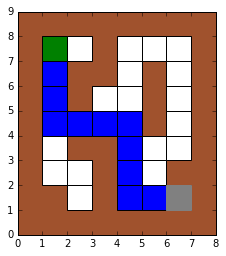

[(4, 9), (4, 8), (5, 8), (5, 7), (5, 6), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (7, 3), (7, 2), (6, 2), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8)]


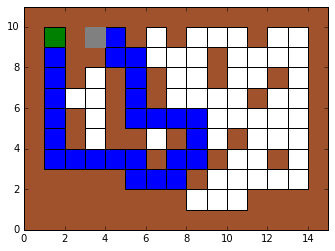

[]


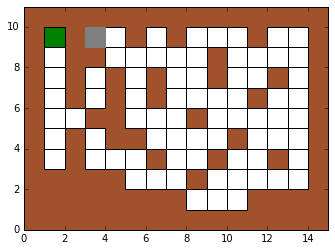

In [63]:
print(heuristic(maze1()))
m1 = maze1()#assign m1 to the maze object
path1 = heuristic(m1) #create the variable path1 and assign the variable to the heuristic path of the object m1
m1.color_graph(path1) #color the graph; call the method color_graph in the maze class and pass in the m1 and path 1 variables
m1.draw() #re-call the draw function


print(heuristic(maze2()))
m2 = maze2()
path2 = heuristic(m2)
m2.color_graph(path2)
m2.draw()

print(heuristic(mazeUnsolvable1()))
m3 = mazeUnsolvable1()
path3 = heuristic(m3)
m3.color_graph(path3)
m3.draw()

You also have to be able to handle switch and door puzzles:

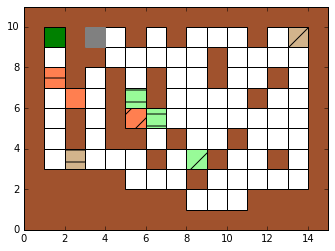

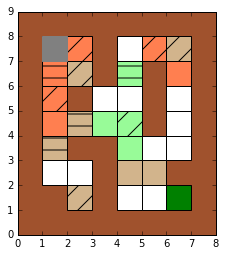

In [64]:
def maze3():
    return Maze([
        "###############",
        "#X#@.#.#...#.1#",
        "#.##.....#....#",
        "#A#.#.#..#..#.#",
        "#.a.#C#....#..#",
        "#.#.#0C.......#",
        "#.#.##.#..#...#",
        "#.B...#.2#..#.#",
        "#####...#.....#",
        "########...####",
        "###############"
    ])

maze3().draw()

def maze4():
    return Maze([
        "########",
        "#@0#.01#",
        "#A1#C#a#",
        "#0#..#.#",
        "#aBc2#.#",
        "#B##c..#",
        "#..#bb##",
        "##1#..X#",
        "########"
    ])

maze4().draw()

[(4, 9), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (8, 9), (9, 9), (10, 9), (10, 8), (11, 8), (12, 8), (12, 9), (13, 9), (13, 9), (12, 9), (12, 8), (11, 8), (10, 8), (10, 9), (9, 9), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 3), (8, 4), (8, 5), (7, 5), (6, 5), (5, 5), (5, 5), (6, 5), (7, 5), (8, 5), (8, 4), (8, 3), (8, 3), (7, 3), (7, 2), (6, 2), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8)]


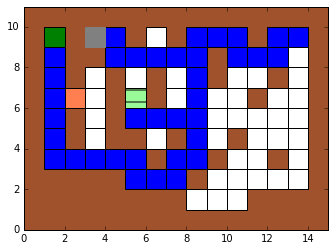

[(2, 7), (2, 7), (2, 6), (2, 6), (1, 6), (1, 5), (1, 5), (1, 4), (2, 4), (3, 4), (4, 4), (4, 4), (4, 5), (4, 6), (4, 7), (5, 7), (6, 7), (6, 7), (6, 6), (6, 5), (6, 4), (6, 3), (5, 3), (5, 2), (5, 1)]


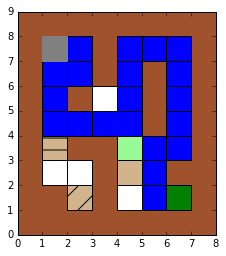

In [56]:
print(heuristic(maze3()))
m4 = maze3()
path4 = heuristic(m4)
m4.color_graph(path4)
m4.draw()

print(heuristic(maze4()))
m5 = maze4()
path5 = heuristic(m5)
m5.color_graph(path5)
m5.draw()

# Assignment 2

Once you have this working, write an agent which finds a policy for a "blind" puzzle using MCTS. "Blind" puzzles are just like the puzzles above, only (a) you don't get to see the whole puzzle or know the goal states in advance, and (b) some nodes are trap doors with a chance of dropping the player into a bottomless pit! Try different policies for deciding between exploit/explore and for doing rollouts and compare them.  Plot graphs on how learning improves with  more rollouts.

Of course, it should also be able to solve the earlier maze puzzles!

In [ ]:
def mcts(maze,iterations):
    # Return the expected value (a number between 0 for "player dead", 1 for "made it to the end")
    # for a budget of `iterations` rollouts.
    # Should also return the best found path (the one most likely to lead to success).
    # Here, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` rollouts, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([], 0)

In [ ]:
def maze5():
    return Maze([
        "#######",
        "#@???X#",
        "#.....#",
        "#######"
    ])

maze5().draw()

def maze6():
    return Maze([
        "#######",
        "#@?!?X#",
        "#.???.#",
        "#.....#",
        "#######"
    ])

maze6().draw()

def maze7():
    return Maze([
        "########",
        "#@0#?01#",
        "#A1#C#a#",
        "#0#.?#!#",
        "#aBc2#.#",
        "#B##c.?#",
        "#.!#bb##",
        "##1#.?X#",
        "########"
    ])

maze7().draw()

# Assignment 3

Do assignment 2 again, but with reinforcement learning! Compare various approaches and parameters (e.g.\ different discounting rates, Sarsa vs Q-learning, etc) against your MCTS agents in terms of iterations required to reach certain levels of performance. Plot graphs showing how learning improves with more iterations. Print or draw out (at least some of) the state-value or action-value matrix.

Read as much as you care to of Sutton & Barto---[section 2](https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node39.html) is especially useful.


In [ ]:
def rl(maze,iterations):
    # Return the best path (most likely to lead to success) along with its expected value and a validated value
    # for a budget of `iterations` experiments.
    # As above, don't look at maze.exit_pos or maze.grid:
    # you're only allowed to query `maze.available_moves()`, `maze.player_alive`, and `maze.is_at_exit`.

    # After training for `iterations` experiments, run an agent through the maze using that learned policy 
    # for a large number of times and return the average reward:
    # (best_path, expected_reward, test_reward)

    return ([],0,0)

# Bonus Assignment

Make an adversary for the maze who is trying to eat the player. Try to get the best performing adversary possible!